In [8]:
# Adapted from https://github.com/opencv/opencv/blob/3.2.0/samples/python/deconvolution.py
import numpy as np
import cv2

def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)

In [9]:
def motion_kernel(angle, d, sz=65):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

In [97]:
def defocus_kernel(d, sz=6):
    kern = np.zeros((sz, sz), np.uint8)
    cv2.circle(kern, (sz, sz), d, 255, -1, cv2.LINE_AA, shift=1)
    kern = np.float32(kern) / 255.0
    return kern

In [98]:
import sys, getopt
import matplotlib.pyplot as plt

def wiener_deconv(img):
    win = 'deconvolution'
    #img_bw = cv2.imread(img, 0)
    #img_rgb = cv2.imread(img, 1)

    #if img_bw is None and img_rgb is None:
        #print('Failed to load image:', img)
        #sys.exit(1)
        
    img_rgb = img
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )

    img_r = np.zeros_like(img_bw)
    img_g = np.zeros_like(img_bw)
    img_b = np.zeros_like(img_bw)

    img_r = img_rgb[..., 2]
    img_g = img_rgb[..., 1]
    img_b = img_rgb[..., 0]

    img_rgb = np.float32(img_rgb)/255.0
    img_bw = np.float32(img_bw)/255.0
    img_r = np.float32(img_r)/255.0
    img_g = np.float32(img_g)/255.0
    img_b = np.float32(img_b)/255.0

    #cv2.imshow('input', img_rgb)
    #plt.imshow(img_rgb)
    #plt.show()

    # img_bw = blur_edge(img_bw)
    img_r = blur_edge(img_r)
    img_g = blur_edge(img_g)
    img_b = blur_edge(img_b)

    # IMG_BW = cv2.dft(img_bw, flags=cv2.DFT_COMPLEX_OUTPUT)
    IMG_R = cv2.dft(img_r, flags=cv2.DFT_COMPLEX_OUTPUT)
    IMG_G = cv2.dft(img_g, flags=cv2.DFT_COMPLEX_OUTPUT)
    IMG_B = cv2.dft(img_b, flags=cv2.DFT_COMPLEX_OUTPUT)

    defocus = True

    #cv2.namedWindow(win)
    #cv2.namedWindow('psf', 0)
    #cv2.createTrackbar('angle', win, 135, 180, update)
    #cv2.createTrackbar('d', win, 22, 50, update)
    #cv2.createTrackbar('SNR (db)', win, 25, 50, update)
    res_rgb = update(win, defocus, img_bw, img_rgb, IMG_R, IMG_G, IMG_B)

    return res_rgb

In [101]:
def update(win, defocus, img_bw, img_rgb, IMG_R, IMG_G, IMG_B):
    #ang = np.deg2rad( cv2.getTrackbarPos('angle', win) )
    ang = 51
    #d = cv2.getTrackbarPos('d', win)
    d = 30
    #noise = 10**(-0.1*cv2.getTrackbarPos('SNR (db)', win))
    noise = .001

    if defocus:
        psf = defocus_kernel(d)
    else:
        psf = motion_kernel(ang, d)
    #cv2.imshow('psf', psf)
    #plt.imshow(psf)
    #plt.show()

    psf /= psf.sum()
    psf_pad = np.zeros_like(img_bw)
    kh, kw = psf.shape
    psf_pad[:kh, :kw] = psf
    PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
    PSF2 = (PSF**2).sum(-1)
    iPSF = PSF / (PSF2 + noise)[...,np.newaxis]

    # RES_BW = cv2.mulSpectrums(IMG_BW, iPSF, 0)
    RES_R = cv2.mulSpectrums(IMG_R, iPSF, 0)
    RES_G = cv2.mulSpectrums(IMG_G, iPSF, 0)
    RES_B = cv2.mulSpectrums(IMG_B, iPSF, 0)


    # res_bw = cv2.idft(RES_BW, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
    res_r = cv2.idft(RES_R, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
    res_g = cv2.idft(RES_G, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
    res_b = cv2.idft(RES_B, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )

    res_rgb = np.zeros_like(img_rgb)
    res_rgb[..., 2] = res_r
    res_rgb[..., 1] = res_g
    res_rgb[..., 0] = res_b

    # res_bw = np.roll(res_bw, -kh//2, 0)
    # res_bw = np.roll(res_bw, -kw//2, 1)
    res_rgb = np.roll(res_rgb, -kh//2, 0)
    res_rgb = np.roll(res_rgb, -kw//2, 1)
    #cv2.imshow(win, res_rgb)
    #plt.imshow(res_rgb)
    #plt.show()
    return res_rgb

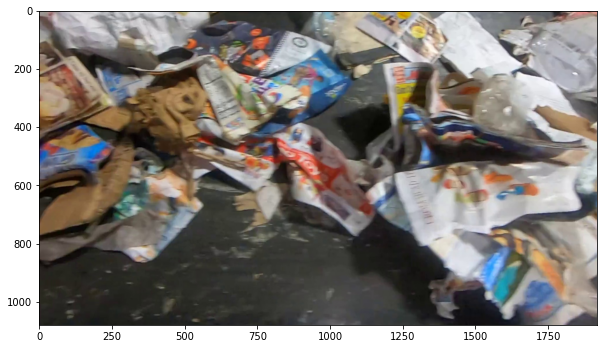

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


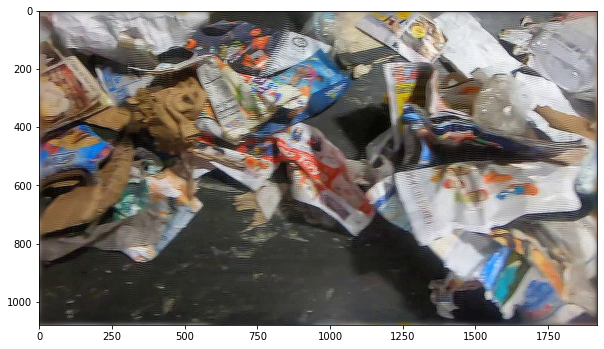

In [102]:
img = cv2.imread('frames/frame1.jpg')
fig, ax = plt.subplots(figsize=(10,18))
im1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax.imshow(im1)
plt.show()
dblr = wiener_deconv(img)
dblr = cv2.cvtColor(dblr, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(10,18))
ax.imshow(dblr)
plt.show()

In [103]:
from os import listdir
from os.path import isfile, join

img_path = "/projectnb/cs585/goutermoutn/imagedeblur/frames/"

np.set_printoptions(threshold=sys.maxsize)

files = [join(img_path,f) for f in listdir(img_path) if isfile(join(img_path,f)) and join(img_path,f).endswith('.jpg')]
files.sort()
imgs = []
for i in range(len(files)):
    imgs.append(cv2.imread(files[i]))
    
print(len(imgs))

25478


In [104]:
count = 0
for image in imgs:
    im_deblur = wiener_deconv(image)
    im_deblur = cv2.convertScaleAbs(im_deblur, alpha=(255.0))
    cv2.imwrite("/projectnb/cs585/goutermoutn/imagedeblur/oof_frames/oof_frame%d.jpg" % count, im_deblur)    
    count += 1
    if count % 500 == 0:
        print("Deblurred "+str(count)+" images...")

Deblurred 500 images...
Deblurred 1000 images...
Deblurred 1500 images...
Deblurred 2000 images...
Deblurred 2500 images...
Deblurred 3000 images...
Deblurred 3500 images...
Deblurred 4000 images...
Deblurred 4500 images...
Deblurred 5000 images...
Deblurred 5500 images...
Deblurred 6000 images...
Deblurred 6500 images...
Deblurred 7000 images...
Deblurred 7500 images...
Deblurred 8000 images...
Deblurred 8500 images...
Deblurred 9000 images...
Deblurred 9500 images...
Deblurred 10000 images...
Deblurred 10500 images...
Deblurred 11000 images...
Deblurred 11500 images...
Deblurred 12000 images...
Deblurred 12500 images...
Deblurred 13000 images...
Deblurred 13500 images...
Deblurred 14000 images...
Deblurred 14500 images...
Deblurred 15000 images...
Deblurred 15500 images...
Deblurred 16000 images...
Deblurred 16500 images...
Deblurred 17000 images...
Deblurred 17500 images...
Deblurred 18000 images...
Deblurred 18500 images...
Deblurred 19000 images...
Deblurred 19500 images...
Deblur